# Qubit-Resonator Design

Senario: We want to design a resonator coupled to a transmon. What kind of parameters need to be determined before drawing a mask

For the resonator, determine:
- $\omega_r$ : resonant (angular) frequency 
- $\kappa$ : linewidth of the resonance

Then calculate:
- $l$ : length of the resonator
- $C_c$ : coupling capacitance to the feedline.

For the transmon, determine:
- $f_{01}$ : qubit frequency
- $\alpha$ : anharmonicity
- $g$ : coupling strength between the resonator and transmon. 
- $\chi$: $\chi$ shift

Then calculate:
- $E_j$ : Josepthon energy
- $E_c$ : Charging energy
- $C_g$ : coupling capacitance between qubit island to the resonator
- $C_s$ : shunt capacitance across Josephson junction

Note on choosing parameters. $g$, $\chi$, $\kappa$, $\Delta$, $\omega_r$.

- For charge-sensitive qubit, small $E_j/E_c$. Charge dispersion and qubit frequency determine $E_j$ and $E_c$ uniquely.
- For a normal transmon, $E_j/E_c = 50-60$.There is a room for anharmoncity. It affects the tyep of gate operation, gate speed, etc.
- Depending on weak-dispersive ($\kappa \gg 2\chi$) vs strong-dispersive ($\kappa\ll2\chi$) vs intermediate regime (for high-fidelity measurement, $\kappa=2\chi$), $\chi$ and $\kappa$ are determined. $\chi=\left(\frac{g^2}{\Delta}\right)\cdot\left(\frac{\alpha}{\Delta+\alpha}\right)$.
- Put relation Qc vs Cc for capacitive and inductive coupling

# CPW, Resonator, Transmon

In [1]:
from math import sqrt, inf, pi, tanh, log, sinh
from scipy.special import ellipk
from scipy.constants import h, hbar, e, epsilon_0, c, mu_0
from scipy import optimize
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

class CPW(object):
    """
    Coplanar Waveguide class
    
       air
    -------------       --------       -----------
       metal    |   s   |  w   |   s   |
    ----------------------------------------------
       dielectric
    ----------------------------------------------
       air
                      
    Parameters
    -----------
    w : width of center conductor in um
    s : gap size between center conductor and GND plane in um
    h : thickness of substrate in um
    t : thickness of metal in um
    epsilon_r: relative permeability of substrate
    metal: type of metal. Need it for kinetic inductance calculation
    kinetic_induct_include : True or False
    
    TODO
    ----
    lambda_L vs thickness for metal.
    
    """
    
    def __init__(self, w=10, s=5, h=500, t=0.1, epsilon_r=11.6, metal='Nb', kinetic_induct_include=False):
        self.w = w
        self.s = s
        self.h = h
        self.t = t
        self.epsilon_r = epsilon_r
        self.metal = metal
        self.kinetic_induct_include = kinetic_induct_include
                    
    @property
    def b(self):
        return self.w + 2 * self.s
    
    @property
    def lambda_L(self):
        """
        London penentration depth of a metal in um. 
        This depends on thickness and temperature, but we assume T=0 since operating temperature is much lower than Tc.
        """
        
        return 0.08 # for 100nm Nb
    
    @property   
    def epsilon_eff(self):
        """
        Effectvie permittivity. Unitless
        Ref: Simmons' book (Schuster thesis)
        No ground plane under Si????
        """        
        k = self.w / self.b
        k3 = tanh(pi*self.w/4/self.h) / tanh(pi*self.b/4/self.h)
        k_p = sqrt(1 - k**2)
        k3_p = sqrt(1 - k3**2)

        K_tilda = ellipk(k_p) * ellipk(k3) / ellipk(k) / ellipk(k3_p)
        epsilon_eff = (1 + self.epsilon_r * K_tilda) / (1 + K_tilda)
        
        return epsilon_eff
    
    @property
    def epsilon_eff_1(self):
        """
        Effectvie permittivity. Unitless
        Ref: Gopple thesis
        """
        epsilon_r1 = 1

        k0 = self.w / self.b
        k0_p = sqrt(1 - k0**2)

        # k1 = sinh(pi*2/4/h1) / sinh(pi*b/4/h1)
        k1=0
        k1_p = sqrt(1 - k1**2)
        k2 = sinh(pi*self.w/4/self.h) / sinh(pi*self.b/4/self.h)
        k2_p = sqrt(1 - k2**2)

        epsilon_eff_1 = (1 
                    + (epsilon_r1 - 1)/2*ellipk(k1)*ellipk(k0_p)/ellipk(k1_p)/ellipk(k0) # This term is zero
                    + (self.epsilon_r - epsilon_r1)/2*ellipk(k2)*ellipk(k0_p)/ellipk(k2_p)/ellipk(k0)
                      )
        
        return epsilon_eff_1
    
    @property
    def Lm_l(self):
        """ 
        Magnetic inductance per unit length, H/m
        Ref: Goople paper, Yosida1995(Schuster thesis): They show the same expressions.
        """
        k0 = self.w / self.b
        k0_p = sqrt(1 - k0**2)
        L_l = mu_0 / 4 * ellipk(k0_p)/ellipk(k0)
        
        return L_l
    
    @property
    def C_l(self):
        """
        Capacitance per unit length, F/m
        Ref: Goople paper
        """
        k0 = self.w / self.b
        k0_p = sqrt(1 - k0**2)
        C_l = 4 * epsilon_0 * self.epsilon_eff * ellipk(k0)/ellipk(k0_p)
        
        return C_l
    
    @property
    def Lk_l(self):
        """
        Kinetic inductance per length on metal
        Ref: Yosida1995 (Schuster thesis)
        """
        
        k = self.w / self.b
        
        g = 1 / (2*(k*ellipk(k))**2) * (-log(self.t/4/self.w) + 2 * (self.w + self.s) / self.b * log(self.s/(self.w + self.s)) \
                                        - self.w/self.b *log(self.t/4/self.b))
        Lk_l = mu_0 * self.lambda_L / (self.w * self.s) * g
        
        return Lk_l
            
    
    @property
    def Z0(self):
        """
        Characteristic impedance of CPW.
        Ref: Simons book (Schuster thesis)
        """
        k = self.w / self.b
        k3 = tanh(pi*self.w/4/self.h) / tanh(pi*self.b/4/self.h)
        k_p = sqrt(1 - k**2)
        k3_p = sqrt(1 - k3**2)
        
        Z0 = 60 * pi / sqrt(self.epsilon_eff) / (ellipk(k)/ellipk(k_p) + ellipk(k3)/ellipk(k3_p))
        
        return Z0
        
class QuarterWaveResonator(CPW):
    """
    CPW quart-wave resonator class. This inherits CPW class.
    
    Parameters
    ----------
    w, a, h, epsilon_s
    w_r : fundamental resonant freq in rad/s
    kappa : linewidh of resonant peak in rad/s
    
    TODO:
    Calculate frequency shift by coupling cap.
    """
    def __init__(self, w_r=None, kappa=None, **kwargs):
        super().__init__(**kwargs)
        self.w_r = w_r
        self.kappa = kappa
                
    def __str__(self):
        out = f'w={self.w} um, s={self.s} um, h={self.h} um, e_r={self.epsilon_r}, f_r={self.w_r/2/pi/1e9 :.3f} GHz, kappa/2pi={self.kappa/2/pi/1e6 :.3f} MHz'
        return out
    
    @property
    def resonator_length(self):
        """
        Calculate the length of resonator in meter. 
        kinetic_induct : True if kinetic inductance is accounted for.
        """
        if self.kinetic_induct_include:
            total_induct_per_length = self.Lm_l + self.Lk_l
        else:
            total_induct_per_length = self.Lm_l
        w_r_pulled = self.get_dressed_res_freq()
        
        l = 1/sqrt(total_induct_per_length * self.C_l) / (w_r_pulled/2/pi) / 4
        
        return l
    
    def get_dressed_res_freq(self):
        w_r_pulled = self.w_r  # TODO: calculate frequency shift by coupling cap.
        return w_r_pulled
    
    @property
    def Qc(self):
        return self.w_r / self.kappa
    
    @property
    def Mc(self):
        """
        Mutual inductance between resonator and feedline, given w_r and kappa.
        Ref: Madison Simulation-and-Design
        """
        M = self.Z0 / self.w_r * sqrt(8/self.Qc/pi)
        
        return M 

class Transmon(object):
    """
    Charge qubit object
    
    Parameters
    ----------
    Ej : Josephson energy in Joule
    Ec : Charging energy in Joule
    N : number of charge states involved for Hamiltonian matrix
    ng_vec : numpy array of gate charge values.
    
    - Use classmethod 'in_GHz' if you want to use GHz unit for Ej and Ec.
    - Usage:  q = Transmon(Ej=10*1e9*h, Ec=0.3*1e9*h) or 
              q = Transmon.in_GHz(Ej=10, Ec=0.3)  
    """
    
    def __init__(self, Ej=0, Ec=0, N=10, ng_vec=np.linspace(-3, 3, 200)):
        self.Ej = Ej 
        self.Ec = Ec 
        self.N = N        
        self.ng_vec = ng_vec
       
    @classmethod
    def in_GHz(cls, Ej=10, Ec=0.3, **kwargs):
        return cls(Ej=Ej*1e9*h, Ec=Ec*1e9*h, **kwargs)
        
    @property
    def energies(self):
        return  self._get_energies()
    
    def _get_energies(self):
        energies = np.array([self.hamiltonian(ng).eigenenergies() for ng in self.ng_vec])
        return energies
    
    def hamiltonian(self, ng):
        """
        Return the charge qubit hamiltonian as a Qobj instance.
        """
        N = self.N
        m = np.diag(4 * self.Ec * (np.arange(-N,N+1)-ng)**2) + 0.5 * self.Ej * (np.diag(-np.ones(2*N), 1) + 
                                                               np.diag(-np.ones(2*N), -1))
        return Qobj(m)

    @property
    def total_cap(self):
        """
        Total capacitance : C_j + C_g + C_s
        C_j : junction capacitance
        C_g : cap. between resonator and qubit
        C_s : shunt capacitance
        """
        return e**2 / self.Ec /2
    
    @property
    def Ej_to_Ec_ratio(self):
        return self.Ej / self.Ec

    @property
    def charge_dispersion(self):
        energies = self.energies  # to evaluate energies once
        f01 = (energies[:,1] - energies[:,0])/h
        charge_dispersion = (f01.max()-f01.min())

        return charge_dispersion
    
    @property
    def anharmonicity(self):
        energies = self.energies  # to evaluate energies once
        f01 = (energies[:,1] - energies[:,0]) / h
        f12 = (energies[:,2] - energies[:,1]) / h
        anharmonicity = (f12-f01).mean() 

        return anharmonicity
    
    @property
    def w01(self):
        """
        qubit frequency in Hz. Average of max and min over ng
        """
        energies = self.energies  # to evaluate energies once
        f01 = (energies[:,1] - energies[:,0]) / h
        freq_01 = (f01.max() + f01.min()) / 2

        return freq_01 * 2 * pi
    
    @property
    def f01(self):
        return self.w01 / 2/ pi
   
    def g01(self, res, C_g):
        """
        Calculate the coupling strength.
        Ref: Koch paper
        
        Parameters:
        res: Resonator object
        C_g: Coupling capacitance between resonator and qubit
        """

        Ej, Ec = self.Ej, self.Ec
        w_r = res.w_r
        C_l = res.C_l
        l = res.resonator_length

        matrix_element_01 = sqrt(1/2)*(Ej/8/Ec)**(1/4)
        beta = C_g / self.total_cap
        #     alpha = e**2 / (4*pi*epsilon_0*hbar*c)

        V0rms = sqrt(hbar * w_r / (C_l * l))
        g_01 = 2 * beta * e * V0rms * matrix_element_01 / hbar

        return g_01
    
    def g01_Madison(self, res, C_g):
        """
        g = 1/2 * Cg /sqrt(Cg+Cs)/sqrt(Cg+Cr)*sqrt(wr*wq)
        Cg: gate capacitance in F
        Cs: qubit shunt capacitance in F
        Cr: lump-element effective capacitance, Cr = C_l * l /2
        wr: resonator frequency, rad/s
        wq: qubit 01 frequency, rad/s
        
        This expression comes from the model that two LC resonators coupled via gate capacitor(Cg).
        Note: I think Cg+Cs should be replaced with Cg+Cs+Cj....
        """
        C_r = res.C_l*res.resonator_length/2
        g_01 = 1/2 * C_g / sqrt(self.total_cap) / sqrt(C_g + C_r) * sqrt(self.w01 * res.w_r)
        
        return g_01
    
    def Chi01(self, res, C_g):
        """
        Ref: Koch paper
        res : Resonator object
        C_g : capacitance between resonator and qubit
        """
        delta = self.w01 - res.w_r
        anharm = self.anharmonicity
        
        Chi01 = self.g01(res, C_g)**2 / delta * (anharm/(anharm + delta)) 
        
        return Chi01
    
    def plot_energies(self, ymax=(20, 3)):
        """
        Plot energy levels as a function of bias parameter ng_vec.
        """
        energies = self.energies  # to evaluate energies once
        
        fig, axes = plt.subplots(1,2, figsize=(16,6))

        for n in range(energies.shape[1]):
            axes[0].plot(self.ng_vec, energies[:,n]/1e9/h)

        axes[0].set_ylim((energies[0,:]/1e9/h).min() * 1.3, ymax[0]) # modified, JK
        axes[0].set_xlabel(r'$n_g$', fontsize=18)
        axes[0].set_ylabel(r'$E_n$', fontsize=18)

        for n in range(energies.shape[1]):
            axes[1].plot(self.ng_vec, (energies[:,n]-energies[:,0])/(energies[:,1]-energies[:,0]))

        axes[1].set_ylim(-0.2, ymax[1])
        axes[1].set_xlabel(r'$n_g$', fontsize=18)
        axes[1].set_ylabel(r'$(E_n-E_0)/(E_1-E_0)$', fontsize=18)
        return fig, axes
    
    def find_Ej_Ec(self, f01, anharm):
        """ 
        Given f01 and anharmonicity, find Ej and Ec.
        Minimize (f01-f(Ej, Ec))**2 + (anharmonictiy- anharm(Ej,Ec))**2 
        Returns Ej and Ec solution.
        """
        sol = optimize.fmin(self._func, [12e9*h, 0.3e9*h], args=(f01, anharm))
        print(f'Ej={sol[0]/h/1e9} GHz, Ec={sol[1]/h/1e9} GHz')
        return sol
    
    def _func(self, x, *args):
        self.Ej = x[0]
        self.Ec = x[1]
#         print(f'Ej={self.Ej}')
#         print(f'Ec={self.Ec}')
        
        return (self.f01 - args[0])**2 +(self.anharmonicity - args[1])**2

#All three classes are in transmonCPW module

In [2]:
# from transmonCPW import CPW, QuarterWaveResonator, Transmon
from math import pi

# Test

In [3]:
# from resonator import QuarterWaveResonator
# from qubit import Transmon

In [61]:
res = QuarterWaveResonator(w=250
                           , s=175
                           , h=500
                           , t=0.1
                           , epsilon_r=11.6
                           , metal='Nb'
                           , kinetic_induct_include=False
                           , w_r=6.4e9 * (2*pi)
                           , kappa=0.3e6 * (2*pi)
                          )
print(res)

w=250 um, s=175 um, h=500 um, e_r=11.6, f_r=6.400 GHz, kappa/2pi=0.300 MHz


In [62]:
res.Z0

50.603681739448604

In [36]:
w, t, l = 2e-3, 0.1e-3, 1 # mm
L = 0.2*l*(np.log(2*l/(w+t))+0.5+(w+t)/3/l)
print(f'L(nH) = {L:.3f}')

L(nH) = 1.472


In [11]:
gamma = (160-96.5)/(160+96.5)
20*np.log10(gamma)

-12.126272883117188

In [31]:
res.Lm_l/1e-6

1.589101546689813e-06

In [12]:
res.resonator_length

0.004665450575163268

In [94]:
res.Lk_l/res.Lm_l

0.021734327555452918

In [119]:
res.Mc

1.4236531206698523e-11

In [28]:
res.Lm_l

2.3272520045524528e-06

In [18]:
print(f'{1e-9/res.Lm_l*1e3} mm')

2.2807131758889314 mm


In [2]:
q = Transmon.in_GHz(Ej=12, Ec=0.30)

In [18]:
q.anharmonicity/1e6

-352.06423089206646

In [19]:
0.3e9*h

1.9878210449999999e-25

In [3]:
sol = q.find_Ej_Ec(4e9, -0.45e9)

Optimization terminated successfully.
         Current function value: 0.000021
         Iterations: 88
         Function evaluations: 170
Ej=6.9528378245419775 GHz, Ec=0.3449478232764514 GHz


In [5]:
(q.Ej, q.Ec) = sol
# Chi01 = self.g01(res, C_g)**2 / delta * (anharm/(anharm + delta)) 
# sqrt((0.9e6 * (6.805-5.285)*1e9))/1e6
print(q.anharmonicity/1e6)
print(q.f01/1e9)
print(q.charge_dispersion/1e6)

-450.0000000043336
3.9999999999984492
5.780699465854645


In [83]:
q.total_cap

6.84136194944555e-14

In [197]:
res.resonator_length * 1e6

4976.509099566019

In [199]:
res.Lk_l / res.Lm_l

0.0590649871378968

In [285]:
res.C_l

1.694637083911534e-10

In [202]:
Cg = 3e-15
print(f'Ej(GHz), Ec, Ej/Ec, charge disp(MHz), f01(GHz), anharm(MHz), g/2pi, Chi/2pi')
print(f'----------------------------------------------------------------------------')
print(f'{q.Ej/1e9/h:.1f}, {q.Ec/1e9/h}, {q.Ej_to_Ec_ratio:.3f},  {q.charge_dispersion/1e6:.3f}, \
         {q.f01/1e9:.3f}, {q.anharmonicity/1e6:.3f}, {q.g01(res, C_g=Cg)/2/pi/1e6:.3f}, {q.Chi01(res, C_g=Cg)/2/pi/1e6:.3f}')

Ej(GHz), Ec, Ej/Ec, charge disp(MHz), f01(GHz), anharm(MHz), g/2pi, Chi/2pi
----------------------------------------------------------------------------
10.0, 0.39, 25.641,  1.810,          5.162, -485.560, 60.005, -0.362


(<matplotlib.figure.Figure at 0x7f7db8bbcd68>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7db895a828>,
       dtype=object))

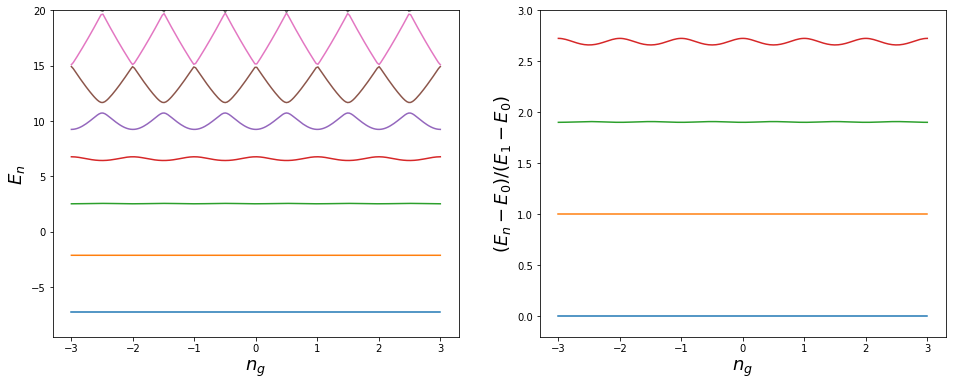

In [179]:
%matplotlib inline
q.plot_energies()

# Anharmonicity vs Ej/Ec for different N

In [211]:
Ej = 10
Ec = np.linspace(0.2,5, 100) 
Ec = np.logspace(-1, 1.5, 50)

Ns = [4, 6, 8, 10, 12]
qs = [Transmon.in_GHz(Ej=Ej,Ec=0, N=n) for n in Ns]
anharms = []

for q in qs:
    anh = np.array([])
    for E in Ec:
        q.Ec = E *1e9*h
        anh = np.append(anh, q.anharmonicity)
    anharms.append(anh)
    

Using matplotlib backend: TkAgg


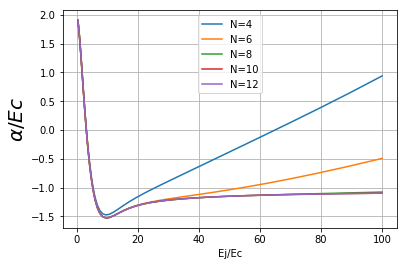

In [212]:
%matplotlib
# import plotly
# import plotly.graph_objs as go
# from plotly.offline import iplot
# plotly.offline.init_notebook_mode(connected=True)

for anh in anharms:        
    plt.plot(Ej/Ec, anh/(Ec*1e9), '-')

plt.tick_params
plt.xlabel('Ej/Ec')
plt.ylabel(r'$\alpha/Ec$', fontsize=20)
plt.grid()
plt.legend([f'N={n}' for n in Ns])

# # iplot
# data = []
# for anh in anharms:
#     data.append(go.Scatter(x=Ej/Ec, y=anh/(Ec*1e9)))
    
# iplot({
#     "data": data,
#     "layout": go.Layout(title="Anharmoniciity vs Ej/Ec")
    
# })

In [151]:
res.get_resonator_length()

0.00497635290192806